# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from Matching import *

curr_dir = mkdirifnotexists(os.path.join('Matching'))

# Load data

In [4]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')

acs_data['ACS sample'], pnp_data['ACS sample'] = 1, 0

pnp_data.index = pnp_data.index.astype(str)
acs_data.index = acs_data.index.astype(str)

# Matching

In [19]:
matching_dir = 'Matching'
pnp_acs_matching_dir = os.path.join('Matching', 'PNP1-ACS_matching')
mkdirifnotexists(pnp_acs_matching_dir)

In [7]:
print (pnp_data.shape, acs_data.shape)
pnp_data_metabolon = pd.read_csv('data/pnp_data_metabolon.csv')
acs_data_metabolon = pd.read_csv('data/acs_data_metabolon.csv')
print (pnp_data_metabolon.shape, acs_data_metabolon.shape)
pnp_data_metabolon_full = pnp_data_metabolon.dropna(subset=['100000010', 'Age', 'gender'])
acs_data_metabolon_full = acs_data_metabolon.dropna(subset=['100000010', 'Age', 'gender'])
print (pnp_data_metabolon_full.shape, acs_data_metabolon_full.shape)

(985, 3478) (202, 3455)
(985, 4440) (202, 4417)
(471, 4440) (156, 4417)


## microbiome No HPN+Dys

In [21]:
acs_data.loc[:, 'DM'] = (acs_data.loc[:, 'Glucose Disorder: DM1']==1) | \
                                    (acs_data.loc[:, 'Glucose Disorder: DM2']==1) | \
                                    (acs_data.loc[:, 'HbA1C']>6.4)

In [22]:
cols_to_match_on = {'gender':'binary', 'Age':'cont', 'bmi':'cont', 'DM':'binary', 'smoke_tobacco_now':'binary'}

print (pnp_data.shape, acs_data.shape)
pnp_data_nextera = pnp_data[(pnp_data.Nextera=='True') & (pnp_data.IsGenotek == 0)].dropna(subset=[pnp_data.filter(regex='k__').columns[0], 'Age', 'gender'])[cols_to_match_on.keys()]
acs_data_nextera = acs_data.dropna(subset=[acs_data.filter(regex='k__').columns[0], 'Age', 'gender'])[cols_to_match_on.keys()]
pnp_data_nextera = pnp_data_nextera[pnp_data_nextera.Age>30]
acs_data_nextera = acs_data_nextera[acs_data_nextera.Age<75]
print (pnp_data_nextera.shape, acs_data_nextera.shape)

(985, 3478) (202, 3456)
(284, 5) (191, 5)


In [23]:
temp_acs = acs_data_nextera[cols_to_match_on.keys()].dropna().copy()
temp_pnp = pnp_data_nextera[cols_to_match_on.keys()].dropna().copy()

temp_acs['ACS sample'] = 1
temp_pnp['ACS sample'] = 0


data_before_matching = pd.concat((temp_pnp, temp_acs)).copy()
data_before_matching

,gender,Age,bmi,DM,smoke_tobacco_now,ACS sample
RegistrationCode,,,,,,
10260,0.0,45.410959,25.593737,False,0.0,0
102855,0.0,37.926027,22.265625,False,1.0,0
107014,0.0,60.704110,23.191095,False,0.0,0
110706,1.0,45.701370,32.449973,False,0.0,0
112871,0.0,33.895890,18.206645,False,0.0,0
...,...,...,...,...,...,...
3770343,1.0,68.632877,27.041644,False,0.0,1
3445026,1.0,67.967123,34.198557,False,0.0,1
3025867,1.0,69.191781,28.400548,True,0.0,1


AttributeError: 'Rectangle' object has no property 'normed'

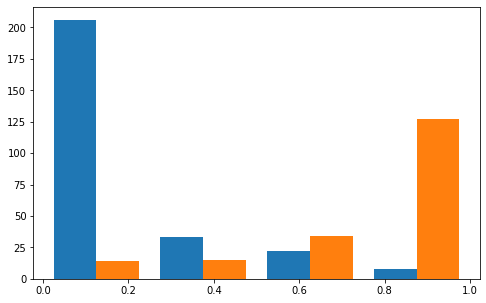

In [24]:
ps_model, pscores = calc_propensity_score_sklearn(data_before_matching, 
                                                  ps_cols=data_before_matching.drop('ACS sample', axis=1).columns, 
                                                  TX_col='ACS sample', model=LogisticRegression(), CV=False)
data_before_matching_and_propensity = data_before_matching.copy()
data_before_matching_and_propensity['propensity'] = pscores

plot_pscores(data_before_matching_and_propensity, TX_col='ACS sample', pscore_col='propensity', 
             TX_values=[0,1], TX_labels=['Healthy', 'ACS'],
             hist=True, normed=False, bin_resolution=0.25)

In [25]:
n_matches_max = 4

matching_n_df = pd.DataFrame(index=range(1, n_matches_max+1), columns=['Number of ACS', 'Number of Healthy'])
matched_dic = {}
for n_matches in tqdm_notebook(range(1, n_matches_max+1)):
    matched_dic[n_matches] = {}
    X_matched = find_propensity_score_matches(data_before_matching_and_propensity, TX_col='ACS sample', pscore_col='propensity',
                                              TX_values=[0,1], caliper=0.3, distance='linear', n_matches=n_matches, random_seed=1)
    matched_cases = X_matched[(X_matched['ACS sample'] == 1) & (X_matched['matched_control_idx'])]
    matched_control = X_matched[(X_matched['ACS sample'] == 0) & (X_matched['matched_control_idx'])]
    matched_dic[n_matches]['X_matched'] = X_matched
    matched_dic[n_matches]['matched_cases'] = matched_cases
    matched_dic[n_matches]['matched_control'] = matched_control
    print (n_matches, matched_cases.shape, matched_control.shape)
    matching_n_df.loc[n_matches, :] = [matched_cases.shape[0], matched_control.shape[0]]
matching_n_df

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


1 (64, 8) (64, 8)
2 (44, 8) (87, 8)
3 (37, 8) (107, 8)
4 (32, 8) (121, 8)



,Number of ACS,Number of Healthy
1,64,64
2,44,87
3,37,107
4,32,121


gender


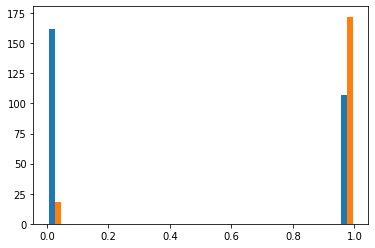

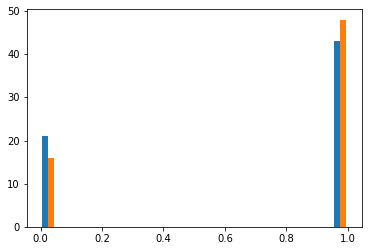

(64, 8) (64, 8)
1.2583354388890575
0.1729803522776138
MannwhitneyuResult(statistic=1888.0, pvalue=0.16651347208292072)
Age


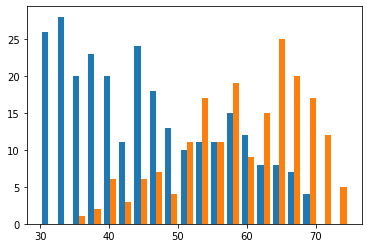

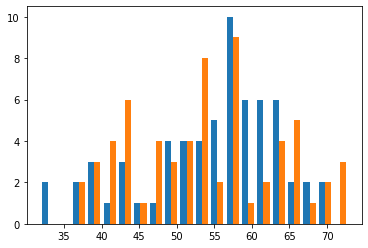

(64, 8) (64, 8)
4.477201337874265
-0.26137745760170106
MannwhitneyuResult(statistic=1905.0, pvalue=0.24853754201902029)
bmi


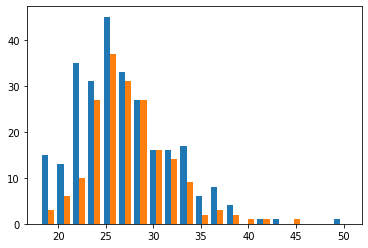

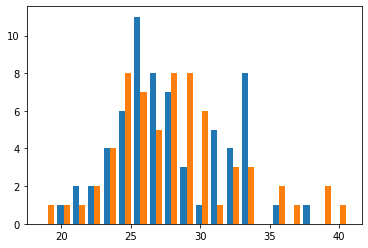

(64, 8) (64, 8)
0.3000481631662238
0.16687999626504613
MannwhitneyuResult(statistic=1954.0, pvalue=0.327947391456449)
DM


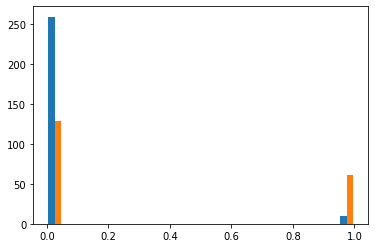

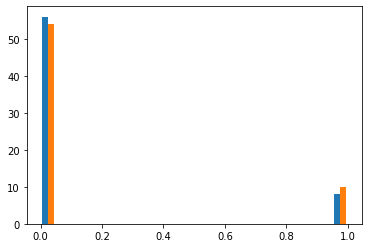

(64, 8) (64, 8)
0.7969405841218401
0.0899842541331695
MannwhitneyuResult(statistic=1984.0, pvalue=0.30763475667881124)
smoke_tobacco_now


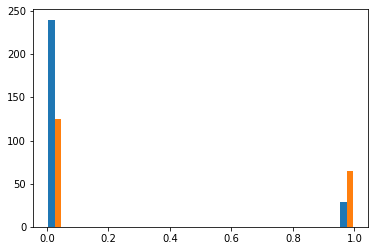

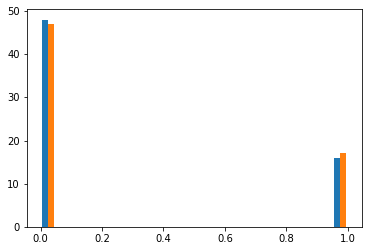

(64, 8) (64, 8)
0.5846024031599185
0.0357256796484452
MannwhitneyuResult(statistic=2016.0, pvalue=0.4214728503376818)


In [27]:
i=1
matched_control, matched_cases = matched_dic[i]['matched_control'], matched_dic[i]['matched_cases']

for c in cols_to_match_on:
    print (c)
    plt.hist([temp_pnp[c].astype(float), temp_acs[c].astype(float)], bins=20)#, normed=True)
    plt.show()
    plt.hist([matched_control[c].astype(float), matched_cases[c].astype(float)], bins=20)#, normed=True)
    plt.show()
    print (matched_control.shape, matched_cases.shape)
    if cols_to_match_on[c] == 'binary':
        print (dichotomous_standadized_difference(temp_pnp[c].astype(int), temp_acs[c].astype(int)))
        print (dichotomous_standadized_difference(matched_control[c].astype(int), matched_cases[c].astype(int)))
    elif cols_to_match_on[c] == 'cont':
        print (continuous_standadized_difference(temp_pnp[c], temp_acs[c]))
        print (continuous_standadized_difference(matched_control[c], matched_cases[c]))
    print (mannwhitneyu(matched_control[c], matched_cases[c]))

<AxesSubplot:xlabel='Standardized differences'>

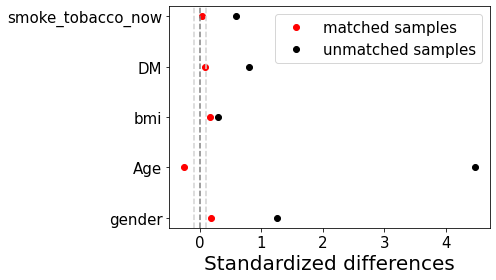

In [28]:
smd_df = pd.DataFrame(index=cols_to_match_on, columns=['matched samples', 'unmatched samples'])
for c in cols_to_match_on:
    if cols_to_match_on[c] == 'binary':
        smd_df.loc[c, 'unmatched samples'] = dichotomous_standadized_difference(temp_pnp[c], temp_acs[c])
        smd_df.loc[c, 'matched samples'] = dichotomous_standadized_difference(matched_control[c], matched_cases[c])
    elif cols_to_match_on[c] == 'cont':
        smd_df.loc[c, 'unmatched samples'] = continuous_standadized_difference(temp_pnp[c], temp_acs[c])
        smd_df.loc[c, 'matched samples'] = continuous_standadized_difference(matched_control[c], matched_cases[c])
    
plot_SMD_before_after_matching(smd_df, figsize=(7,4)) # ['BMI', 'Sex', 'Age']
# plt.savefig(os.path.join(d2_acs_matching_dir, 'D2_RegistrationCode.png'), dpi=200)

In [30]:
smd_df.to_csv(os.path.join(pnp_acs_matching_dir, 'PNP1-ACS_microbiome_age+sex+bmi+DM+smoking_1:1_SMD.csv'))

In [328]:
pd.concat((matched_dic[1]['matched_control'], matched_dic[1]['matched_cases']), axis=0, sort=False).to_csv(os.path.join(pnp_acs_matching_dir, 'PNP1-ACS_microbiome_age+sex+bmi+DM+smoking_1:1.csv'))

## No HPN+Dyslipidemia

In [9]:
acs_data_metabolon_full.loc[:, 'DM'] = (acs_data_metabolon_full.loc[:, 'Glucose Disorder: DM1']==1) | \
                                                                (acs_data_metabolon_full.loc[:, 'Glucose Disorder: DM2']==1) | \
                                                                (acs_data_metabolon_full.loc[:, 'HbA1C']>6.4)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [10]:
acs_data_metabolon_full['Dyslipidemia'] = acs_data_metabolon_full['Dyslipidemia_asin_PNP']

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
cols_to_match_on = {'gender':'binary', 'Age':'cont', 'bmi':'cont', 'DM':'binary', 'smoke_tobacco_now':'binary'}
temp_pnp = pnp_data_metabolon_full.loc[:, cols_to_match_on.keys()].dropna().copy()

temp_acs = acs_data_metabolon_full.loc[:, cols_to_match_on.keys()].dropna().copy()

temp_acs['ACS sample'] = 1
temp_pnp['ACS sample'] = 0


data_before_matching = pd.concat((temp_pnp, temp_acs)).copy()
data_before_matching

,gender,Age,bmi,DM,smoke_tobacco_now,ACS sample
RegistrationCode,,,,,,
10260,0.0,45.410959,25.593737,False,0.0,0
103543,0.0,60.008219,23.805402,False,0.0,0
105043,1.0,58.386301,34.018913,True,0.0,0
107014,0.0,60.704110,23.191095,False,0.0,0
109179,1.0,68.219178,26.573129,False,0.0,0
...,...,...,...,...,...,...
3693158,1.0,54.284932,24.489796,False,1.0,1
3005299,1.0,67.194521,26.573129,True,0.0,1
3624698,1.0,62.589041,36.419753,True,0.0,1


AttributeError: 'Rectangle' object has no property 'normed'

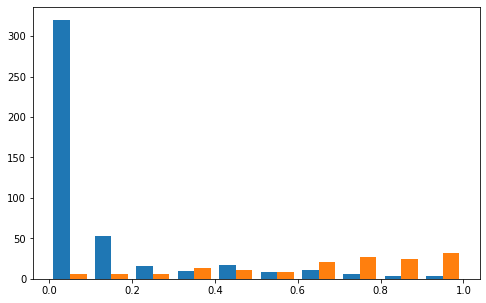

In [12]:
ps_model, pscores = calc_propensity_score_sklearn(data_before_matching, 
                                                  ps_cols=data_before_matching.drop('ACS sample', axis=1).columns, 
                                                  TX_col='ACS sample', model=LogisticRegression(), CV=False)
data_before_matching_and_propensity = data_before_matching.copy()
data_before_matching_and_propensity['propensity'] = pscores

plot_pscores(data_before_matching_and_propensity, TX_col='ACS sample', pscore_col='propensity', 
             TX_values=[0,1], TX_labels=['Healthy', 'ACS'],
             hist=True, normed=False, bin_resolution=0.1)

In [13]:
n_matches_max = 3

matching_n_df = pd.DataFrame(index=range(1, n_matches_max+1), columns=['Number of ACS', 'Number of Healthy'])
matched_dic = {}
for n_matches in tqdm_notebook(range(1, n_matches_max+1)):
    matched_dic[n_matches] = {}
    X_matched = find_propensity_score_matches(data_before_matching_and_propensity, TX_col='ACS sample', pscore_col='propensity',
                                              TX_values=[0,1], caliper=0.4, distance='linear', n_matches=n_matches, random_seed=2)
    matched_cases = X_matched[(X_matched['ACS sample'] == 1) & (X_matched['matched_control_idx'])]
    matched_control = X_matched[(X_matched['ACS sample'] == 0) & (X_matched['matched_control_idx'])]
    matched_dic[n_matches]['X_matched'] = X_matched
    matched_dic[n_matches]['matched_cases'] = matched_cases
    matched_dic[n_matches]['matched_control'] = matched_control
    print (n_matches, matched_cases.shape, matched_control.shape)
    matching_n_df.loc[n_matches, :] = [matched_cases.shape[0], matched_control.shape[0]]
matching_n_df

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


1 (83, 8) (83, 8)
2 (58, 8) (111, 8)
3 (46, 8) (133, 8)



,Number of ACS,Number of Healthy
1,83,83
2,58,111
3,46,133


gender


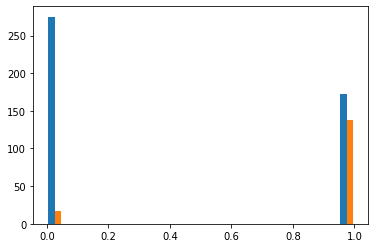

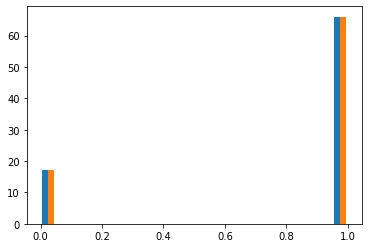

(83, 8) (83, 8)
1.2324358893048337
0.0
MannwhitneyuResult(statistic=3444.5, pvalue=0.4990783900919022)
Age


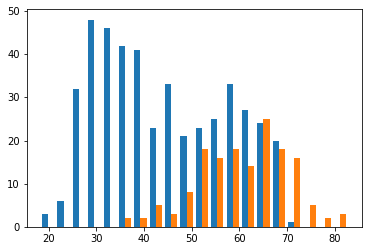

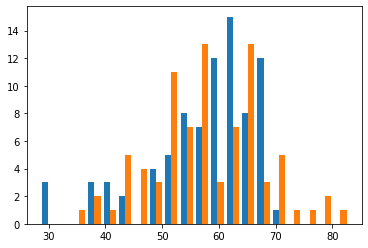

(83, 8) (83, 8)
4.875318158056946
0.13399771134445587
MannwhitneyuResult(statistic=3334.0, pvalue=0.36119702998485237)
bmi


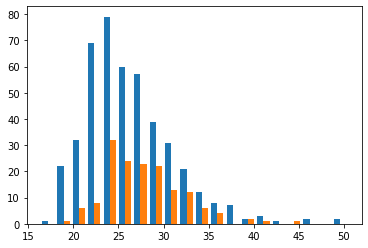

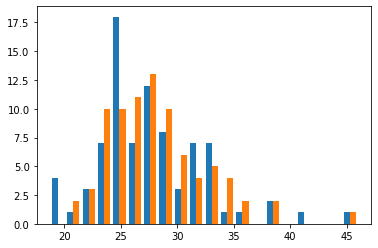

(83, 8) (83, 8)
0.5745031404680303
0.1716223630857561
MannwhitneyuResult(statistic=3228.0, pvalue=0.24270674609970444)
DM


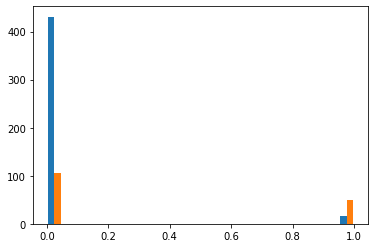

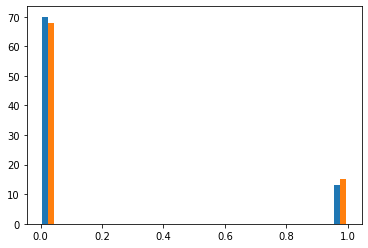

(83, 8) (83, 8)
0.7826076589245038
0.06438227799796503
MannwhitneyuResult(statistic=3361.5, pvalue=0.3406100023243921)
smoke_tobacco_now


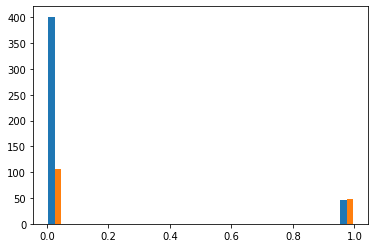

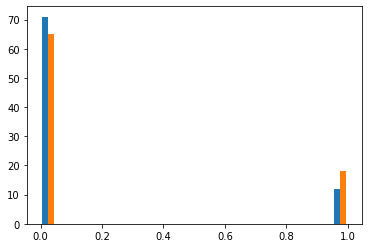

(83, 8) (83, 8)
0.5220636508386026
0.18870163911673174
MannwhitneyuResult(statistic=3195.5, pvalue=0.11426066234302079)


In [15]:
i=1
matched_control, matched_cases = matched_dic[i]['matched_control'], matched_dic[i]['matched_cases']

for c in cols_to_match_on:
    print (c)
    plt.hist([temp_pnp[c].astype(float), temp_acs[c].astype(float)], bins=20)#, normed=True)
    plt.show()
    plt.hist([matched_control[c].astype(float), matched_cases[c].astype(float)], bins=20)#, normed=True)
    plt.show()
    print (matched_control.shape, matched_cases.shape)
    if cols_to_match_on[c] == 'binary':
        print (dichotomous_standadized_difference(temp_pnp[c].astype(int), temp_acs[c].astype(int)))
        print (dichotomous_standadized_difference(matched_control[c].astype(int), matched_cases[c].astype(int)))
    elif cols_to_match_on[c] == 'cont':
        print (continuous_standadized_difference(temp_pnp[c], temp_acs[c]))
        print (continuous_standadized_difference(matched_control[c], matched_cases[c]))
    print (mannwhitneyu(matched_control[c], matched_cases[c]))

<AxesSubplot:xlabel='Standardized differences'>

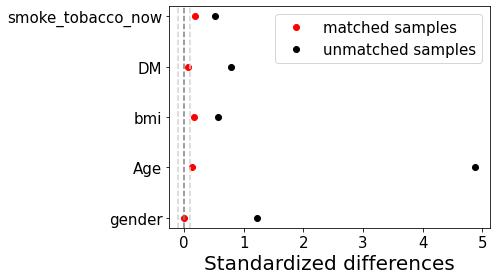

In [16]:
smd_df = pd.DataFrame(index=cols_to_match_on, columns=['matched samples', 'unmatched samples'])
for c in cols_to_match_on:
    if cols_to_match_on[c] == 'binary':
        smd_df.loc[c, 'unmatched samples'] = dichotomous_standadized_difference(temp_pnp[c], temp_acs[c])
        smd_df.loc[c, 'matched samples'] = dichotomous_standadized_difference(matched_control[c], matched_cases[c])
    elif cols_to_match_on[c] == 'cont':
        smd_df.loc[c, 'unmatched samples'] = continuous_standadized_difference(temp_pnp[c], temp_acs[c])
        smd_df.loc[c, 'matched samples'] = continuous_standadized_difference(matched_control[c], matched_cases[c])
    
plot_SMD_before_after_matching(smd_df, figsize=(7,4)) # ['BMI', 'Sex', 'Age']
# plt.savefig(os.path.join(d2_acs_matching_dir, 'D2_RegistrationCode.png'), dpi=200)

In [20]:
smd_df.to_csv(os.path.join(pnp_acs_matching_dir, 'PNP1-ACS_metabolon_age+sex+bmi+DM+smoking_1:1_SMD.csv'))

In [268]:
pd.concat((matched_dic[1]['matched_control'], matched_dic[1]['matched_cases']), axis=0, sort=False).to_csv(os.path.join(pnp_acs_matching_dir, 'PNP1-ACS_metabolon_age+sex+bmi+DM+smoking_1:1.csv'))